# Peer-graded Assignment: Week 4: NLP Disaster Tweets Kaggle Mini-Project

## Author: Tung Anh Nguyen Sy

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [4]:
# Setup

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#### About:

The project is about the NLP Disaster Tweet [kaggle competition](https://www.kaggle.com/competitions/nlp-getting-started/overview). It is stated as follows:

> Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).
> 
> But, it’s not always clear whether a person’s words are actually announcing a disaster.
> 
> In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. 

The dataset consists of roughly 10.000 manually labelled tweets. If available, it contains information regarding keywords and location, but most importantly the text of the tweet and the target label (1 for disaster, 0 for other).

In [5]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### EDA:

The first step is, as always, to look at the dataset. From the EDA, we can see that the dataset is roughly balanced. We can also see that the distribution of word counts per tweet for regular and disaster tweets do not appear to be any different. Also, creating seperate word clouds for regular and disaster tweets is insightful. It shows that disaster tweets have some specific words in it (like death, killed, storm, flood) that are not as frequent in regular tweets.

Still, the EDA suggests that there is no easy separation between the two labels and, therefore, sequence based algorithms, such as LSTMs, should be used for classification.

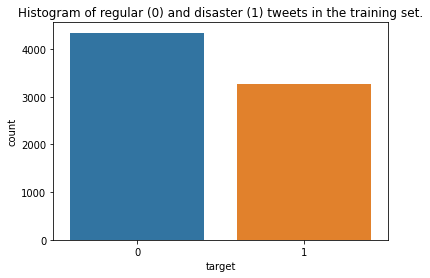

In [6]:
sns.countplot(x=df_train['target']).set(title='Histogram of regular (0) and disaster (1) tweets in the training set.');

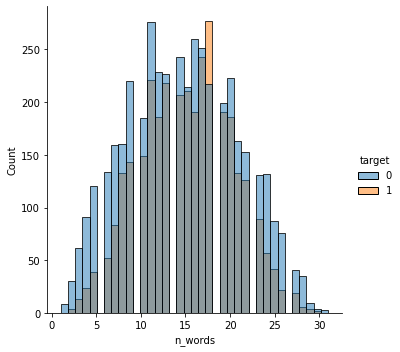

In [7]:
# Is the word count per tweet different between 0 and 1?
df_train['n_words'] = df_train['text'].str.split().apply(len)
sns.displot(df_train, x="n_words", hue="target");

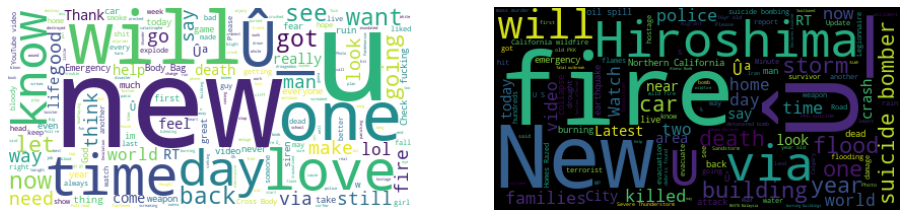

In [8]:
# Create text corpus
regular = " ".join(tweet for tweet in df_train["text"].loc[df_train["target"]==0])
disaster = " ".join(tweet for tweet in df_train["text"].loc[df_train["target"]==1])
stopwords = set(STOPWORDS)
stopwords.update(["t", "co", "https", "amp", "people"])

# Create and generate word clouds
wordcloud_reg = WordCloud(stopwords=stopwords, background_color="white").generate(regular)
wordcloud_dis = WordCloud(stopwords=stopwords, background_color="black").generate(disaster)

# Display the generated images
fig = plt.figure(figsize=(16, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(wordcloud_reg, interpolation='bilinear')
plt.axis("off")
fig.add_subplot(1, 2, 2)
plt.imshow(wordcloud_dis, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Model:

As a baseline, I manually came up with a classifier that predicts disasters based on the most apparent words in the word cloud (see section above). This classifier reached an accuracy of about 66%.

For the initial LSTM-based model, I used a relatively small model with roughly 60,000 parameters. This model was able to achieve around 77% validation accuracy, although some overfitting to the training set was apparent. The next section will try to find a better, alternative model.

In [9]:
train, valid = train_test_split(df_train, test_size=0.2)

In [10]:
# Create a manual baseline classifier
def vanilla_pred(str):
    keywords =  ["fire", "death", "killed", "storm", "flood", "Hiroshima", "crash", "emergency", "eartquake", "suicide"]
    return int(any(word in str for word in keywords))
valid["pred"] = valid["text"].apply(vanilla_pred)
acc = len(valid.loc[valid["target"]==valid["pred"]])/len(valid)
print("Accuracy of baseline classifier: {0:.4f}".format(acc))

Accuracy of baseline classifier: 0.6573


In [11]:
# Vectorize corpus
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

N_WORDS = 500
MAX_LEN = 25

tok = Tokenizer(num_words = N_WORDS, 
                      oov_token = '<OOV>')
tok.fit_on_texts(train["text"])

train_seq = tok.texts_to_sequences(train["text"])
train_pad = pad_sequences(train_seq,
                                maxlen = MAX_LEN)

valid_seq = tok.texts_to_sequences(valid["text"])
valid_pad = pad_sequences(valid_seq,
                               maxlen = MAX_LEN)



In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=500,
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.build(input_shape=(64, 25))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
model.summary()

2023-01-03 13:02:33.463522: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          32000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 58,945
Trainable params: 58,945
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(train_pad,
                    train["target"],
                    epochs=10, 
                    validation_data=(valid_pad, valid["target"]),
                    verbose=2)

Epoch 1/10


2023-01-03 13:02:35.391909: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


191/191 - 22s - loss: 0.6610 - accuracy: 0.6668 - val_loss: 0.5809 - val_accuracy: 0.7590
Epoch 2/10
191/191 - 10s - loss: 0.5498 - accuracy: 0.7429 - val_loss: 0.6327 - val_accuracy: 0.6467
Epoch 3/10
191/191 - 10s - loss: 0.4993 - accuracy: 0.7846 - val_loss: 0.5747 - val_accuracy: 0.7689
Epoch 4/10
191/191 - 10s - loss: 0.4671 - accuracy: 0.7995 - val_loss: 0.5264 - val_accuracy: 0.7702
Epoch 5/10
191/191 - 10s - loss: 0.4381 - accuracy: 0.8200 - val_loss: 0.6098 - val_accuracy: 0.7722
Epoch 6/10
191/191 - 10s - loss: 0.4217 - accuracy: 0.8220 - val_loss: 0.5354 - val_accuracy: 0.7774
Epoch 7/10
191/191 - 11s - loss: 0.4033 - accuracy: 0.8309 - val_loss: 0.5899 - val_accuracy: 0.7643
Epoch 8/10
191/191 - 10s - loss: 0.3875 - accuracy: 0.8338 - val_loss: 0.7001 - val_accuracy: 0.7656
Epoch 9/10
191/191 - 10s - loss: 0.3974 - accuracy: 0.8320 - val_loss: 0.6642 - val_accuracy: 0.7702
Epoch 10/10
191/191 - 10s - loss: 0.3834 - accuracy: 0.8419 - val_loss: 0.7729 - val_accuracy: 0.7649


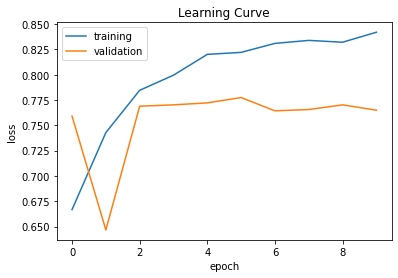

In [19]:
def plot_learning_curve(hist):
    history = hist.history
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Learning Curve')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show();
    
plot_learning_curve(history)

#### Results and Analysis:

The optimized model was able to achieve an increased accuracy of 80% (when applying early stopping), although there is still some overfitting. For this, I used a larger word embedding layer, more units for the LSTM and dropout as a regularization method. The dropout rate was tuned manually.

In [14]:
N_WORDS = 2000
MAX_LEN = 25

tok = Tokenizer(num_words = N_WORDS, 
                      oov_token = '<OOV>')125
tok.fit_on_texts(train["text"])

train_seq = tok.texts_to_sequences(train["text"])
train_pad = pad_sequences(train_seq,
                                maxlen = MAX_LEN)

valid_seq = tok.texts_to_sequences(valid["text"])
valid_pad = pad_sequences(valid_seq,
                               maxlen = MAX_LEN)

In [24]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=2000,
        output_dim=128,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.75, recurrent_dropout=0.5)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model2.build(input_shape=(64, 25))
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         256000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 358,977
Trainable params: 358,977
Non-trainable params: 0
_________________________________________________________________


In [25]:
history2 = model2.fit(train_pad,
                    train["target"],
                    epochs=10, 
                    validation_data=(valid_pad, valid["target"]),
                    verbose=2)

Epoch 1/10
191/191 - 46s - loss: 0.8611 - accuracy: 0.6144 - val_loss: 0.5071 - val_accuracy: 0.7715
Epoch 2/10
191/191 - 37s - loss: 0.5719 - accuracy: 0.7562 - val_loss: 0.8809 - val_accuracy: 0.6198
Epoch 3/10
191/191 - 38s - loss: 0.5302 - accuracy: 0.7782 - val_loss: 0.5037 - val_accuracy: 0.7958
Epoch 4/10
191/191 - 37s - loss: 0.5769 - accuracy: 0.7516 - val_loss: 0.5212 - val_accuracy: 0.7163
Epoch 5/10
191/191 - 37s - loss: 0.5032 - accuracy: 0.7874 - val_loss: 0.5360 - val_accuracy: 0.7590
Epoch 6/10
191/191 - 37s - loss: 0.4977 - accuracy: 0.8079 - val_loss: 0.6594 - val_accuracy: 0.7879
Epoch 7/10
191/191 - 37s - loss: 0.4664 - accuracy: 0.8342 - val_loss: 0.6935 - val_accuracy: 0.7919
Epoch 8/10
191/191 - 38s - loss: 0.4264 - accuracy: 0.8391 - val_loss: 0.5733 - val_accuracy: 0.7840
Epoch 9/10
191/191 - 38s - loss: 0.4196 - accuracy: 0.8498 - val_loss: 0.7636 - val_accuracy: 0.7899
Epoch 10/10
191/191 - 37s - loss: 0.3977 - accuracy: 0.8655 - val_loss: 0.7478 - val_accura

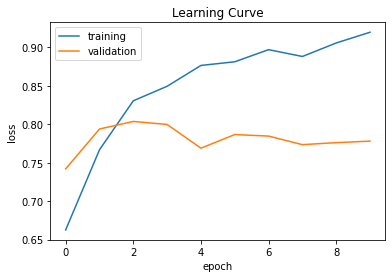

In [23]:
plot_learning_curve(history2)

#### Conclusion:

The final model got an accuracy of around 80%, which was also my score on the leaderboard. The LSTM-based model showed a decent performance, although accuracies above 80% are reachable from looking at the leaderboard (ignoring the obivously leaked 1.0 scores typical for kaggle learning competitions). Using more advanced language models, such as BERT and advanced preprocessing techniques, such as TF-IDF, should increase the score further.

In [26]:
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test_seq = tok.texts_to_sequences(test["text"])
test_pad = pad_sequences(test_seq, maxlen = MAX_LEN)
preds = model2.predict(test_pad)

In [29]:
df_sub = pd.DataFrame()
df_sub['id'] = test['id']
df_sub['target'] = list(map(lambda x: 0 if x < 0.5 else 1, preds))
df_sub.to_csv('submission.csv', index=False)